# 2017-10-13  Getting started on the KaggleInClass Challenge

The goal of this lab is to get started on the KaggleInClass Challenge, setting up a proper cross-validation and trying out a Naive Bayes classifier on it.

In this competition, you will be challenged to predict the number of shares an article will get on social media, from the article's topic, length, day of publication, and many other features.

You are given labels, that is, number of shares, for 5000 of these articles; your task is to predict labels for the remaining 2000 articles.

In [2]:
# load useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Model Selection: setting up a cross validation

Cross-validation is a good way to perform model selection empirically while avoiding overfitting. 

This procedure can be split into the following two steps: 
* the dataset is randomly split into K folds 
* the model is run K times, each run using K-1 folds as the training set and evaluating the performance on the remaining fold which is the test set. 

Prediction performance are averaged over all folds. 

When the model contains parameters that need to be tuned, the CV scheme is repeated for all considered values of the hyperparameters, and those leading to the best prediction performance averaged on all folds are retained.

Depending on the size of the dataset, 5 or 10 folds are usualy considered.

__Question:__ In a K-fold cross-validation, how many times does each sample appear in a test set? In a training set?  

__Answer:__<br/>
K - 1 times in test set<br/>
1 time in a training set

**Question:** Implement a function which splits the _indices_ of the training data in K folds.

In [3]:
def make_Kfolds(n_instance, n_folds):
    """
    set up a K-fold croos-validation.
    
    Parameters:
    -----------
    n_instances: int
        the number of instances in the dataset.
    n_folds: int
        the number of folds of the cross-validation scheme
        
    Outputs:
    --------
    fold_list: list
        list of folds, a fold is a tuple of 2 lists, 
            the first one containing the indices of instances of the training set,
            the second one containing the indices of instances of the test set
    """
    # Create a list of the n_instance indices [0, 1, ..., n_instance-1]
    list_indices = [i for i in range(n_instance)]
    # Shuffle the list with np.random.shuffle
    # TODO
    np.random.shuffle(list_indices)
   # np.random.shuffle(list_indices)
    
    # Compute the number of instances per fold (i.e. in each test set)
    n_instance_per_fold = int(n_instance/n_folds)
    print(n_instance_per_fold)
    
    # For each of the first K-1 folds, create the list of train set and test set indices
    fold_list = []
    start_index = 0
    for ind_fold in range(n_folds-1):
        end_index = start_index + n_instance_per_fold
        test_list = list_indices[start_index:end_index]
        train_list = list_indices[:start_index]+list_indices[end_index:]
        start_index = end_index
        fold_list.append((train_list,test_list))
        
    # Process the last fold separately
    test_list = list_indices[start_index:]
    train_list = list_indices[:start_index]
    fold_list.append((train_list,test_list))  
    
    return fold_list



In [4]:
# Check whether your function does what is expected
perso_folds = make_Kfolds(1001, 5)
for ix, (tr, te) in enumerate(perso_folds):
    print("Fold %d" % ix)
    print("\t %d training points" % len(tr))
    print("\t %d test points" % len(te))
    if len(np.intersect1d(tr, te))>0:
        print('some instances are both in your training and test sets')

200
Fold 0
	 801 training points
	 200 test points
Fold 1
	 801 training points
	 200 test points
Fold 2
	 801 training points
	 200 test points
Fold 3
	 801 training points
	 200 test points
Fold 4
	 800 training points
	 201 test points


In practice, when using scikit-learn, you will not implement your cross-validation yourself, but rather rely on the  library's functionalities for setting up cross-validation schemes. 

[Here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) is the list of available tools in the scikit-learn library.

We list here one of the most important ones:
* [K-fold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): Provides train/test indices to split data in train/test sets by dataset into k consecutive folds (without shuffling by default). 
* [stratified K-fold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) (to be used in case of classification): this cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

We will now explore the stratified K-fold on randomly generated data.

In [5]:
# Generate random data
n_instances, n_features = 1000, 7
# Design matrix
X = np.random.random((n_instances, n_features))
# Classification labels
y = np.where(np.random.random(n_instances) >=0.5, 1, 0)
print(y)

[1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1
 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1
 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0
 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0
 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1
 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0
 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1
 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 1
 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1
 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 1
 1 0 1 1 1 1 0 1 0 1 0 1 

**Question:** Using scikit-learn, set up a stratified 10-fold cross-validation for the above data.

In [6]:
from sklearn import model_selection
# Initialize a StratifiedKFold object 
skf = model_selection.StratifiedKFold(10)
# Split the data using skf
sk_folds = skf.split(X,y)# TODO

In [7]:
# This is one way to access the training and test points
for ix, (tr, te) in enumerate(sk_folds):
    print("Fold %d" % ix)
    print("\t %d training points" % len(tr))
    print("\t %d test points" % len(te))

Fold 0
	 899 training points
	 101 test points
Fold 1
	 899 training points
	 101 test points
Fold 2
	 900 training points
	 100 test points
Fold 3
	 900 training points
	 100 test points
Fold 4
	 900 training points
	 100 test points
Fold 5
	 900 training points
	 100 test points
Fold 6
	 900 training points
	 100 test points
Fold 7
	 900 training points
	 100 test points
Fold 8
	 901 training points
	 99 test points
Fold 9
	 901 training points
	 99 test points


__Important note:__ `sk_folds` is a [_generator_](https://wiki.python.org/moin/Generators), meaning that once you are done looping through it, it will be empty. In practice it avoids storing all the indices (if you were doing 10-fold cross-validation on a million sample, you would have $10^7$ values to store).

**Question:** Create a cross-validation function that takes a design matrix, label array, scikit-learn classifier, and scikit-learn cross_validation object and returns the corresponding list of cross-validated predictions. 

The function contains a loop that goes through all folds and for each fold:
* trains a model on the training data
* uses this model to make predictions on the test data. 
In this fashion you should be able to form *a single vector of predictions* `y_prob_cv` (as each point from the data appears once as a test point in the cross-validation).

Make sure that you are returning the predictions in the correct order!

Check the documentation of fit(X, y) and predict_proba(X) in [sklearn.naive_bayes.GaussianNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). Every classifier implemented in scikit-learn has a fit(X,y) and a predict_proba(X) methods. 
Note that the predict_proba methods returns a 2 dimentional array, you must find a way to only keep the probability to belong to the positive class.

In [8]:
def cross_validate(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        classifier.fit(design_matrix[tr],labels[tr])
        fold_prediction = classifier.predict_proba(design_matrix[te])
        pred[te] = fold_prediction[1]
    return pred

In [9]:
# To check whether your function runs properly, you can use the following

# import Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# create a GNB classifier
gnb = GaussianNB()

# run your cross_validate function
y_prob_cv = cross_validate(X, y, gnb, sk_folds)

# check y and y_prob_cv have the same length (the number of instance)
print(len(y_prob_cv))
print(len(y))

# check the accuracy of your prediction (it should be close to 0.5 as we're considering random matrices). 
print(metrics.accuracy_score(y, np.where(y_prob_cv>=0.5, 1, 0)))

1000
1000
0.522


** Extensions **
* **Leave-one-out cross-validation: ** in this case, the number of folds is the number of available points in the dataset. To say it differently, the model is trained K times on K-1 points, and tested on the left out point. The LOO CV scheme is particularly convenient when the number of samples is very small. When the number of samples is large, it becomes computationally burdensome; moreover the cross-validated error tends to have a very large variance which makes it hard to interpret.

* **Nested-cross-validation: ** The goal of the cross validation scheme is to assess the performance of the model on _new_ data which were not used to train or optimize the model. From that perspective, the CV scheme is not rigorous when optimizing hyperparameters. Indeed, the test data are both used to assess the performance and choosing the set of parameters which led to that best performance. To avoid selecting a possibly over-fitted set of parameters, we also used the so-called nested cross validation (_Nested CV_) scheme which consists in a cross validation (_inner-CV_) nested in a other cross validation (_outer-CV_). At each step of the _outer-CV_, the optimal parameters are found via the _inner-CV_ on the train set of the _outer-CV_, and the performance is assessed on the remaining test fold of the _outer-CV_ Therefore, in _Nested CV_, parameter optimization and performance assessment are performed on different _unseen_ data.


# 1. Data loading and visualization

In [10]:
# we display the description of the features
!cat data/kaggle_data/features.txt

nb_words_title  Number of words in the article's titles
nb_words_content  Number of words in the article
pp_uniq_words  Proportion of unique words in the article
pp_stop_words  Proportion of stop words (i.e. words predefined to be too common to be of use for interpretation or queries, such as 'the', 'a', 'and', etc.)
pp_uniq_non-stop_words  Proportion of non-stop words among unique words
nb_links  Number of hyperlinks in the article
nb_outside_links  Number of hyperlinks pointing to another website
nb_images  Number of images in the article
nb_videos  Number of videos in the article
ave_word_length  Average word length
nb_keywords  Number of keywords in the metadata
category  Category of the article: 0-Lifestyle, 1-Entertainment, 2-Business, 3-Web, 4-Tech, 5-World
nb_mina_mink  Minimum number of share counts among all articles with at least one keyword in common with the article
nb_mina_maxk  Minimum number of maximum share counts per keyword
nb_mina_avek  Minimum number of average sha

In [34]:
feature_data = pd.read_csv('data/kaggle_data/features.txt', header=None, sep="  ", names=['feature_names', 'feature_description'])
feature_data.head(5)

/Users/XQ/envs/scipy35/lib/python3.5/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,feature_names,feature_description
0,nb_words_title,Number of words in the article's titles
1,nb_words_content,Number of words in the article
2,pp_uniq_words,Proportion of unique words in the article
3,pp_stop_words,Proportion of stop words (i.e. words predefine...
4,pp_uniq_non-stop_words,Proportion of non-stop words among unique words


** Now, let's load and look at the distribution of number of shares (output). **

In [35]:
target_data = pd.read_csv('data/kaggle_data/train-targets.csv', sep=",")
target_data.head(5)

,Id,Prediction
0,2000,882
1,2001,1102
2,2002,1102
3,2003,1001
4,2004,1603


(0, 10000)

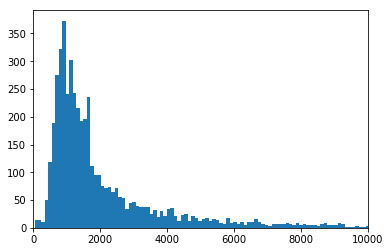

In [13]:
y_tr = target_data['Prediction'].values
plt.hist(y_tr,bins=2000)
plt.xlim((0,10000))

** Now, let's load and visualize the features. **

In [37]:
list_feature_names = list(feature_data['feature_names'])

train_data = pd.read_csv('data/kaggle_data/train.csv', header=None, sep=" ", names=list_feature_names)
train_data.head(5)

,nb_words_title,nb_words_content,pp_uniq_words,pp_stop_words,pp_uniq_non-stop_words,nb_links,nb_outside_links,nb_images,nb_videos,ave_word_length,...,pp_neg_words,pp_pos_words_in_nonneutral,ave_polar_pos,min_polar_pos,max_polar_pos,ave_polar_neg,min_polar_neg,max_polar_neg,subj_title,polar_title
2000,9,843,0.5358,2.092000e-09,0.7469,15.0,8,11,1,4,...,0.019230,0.7143,0.4437,0.03333,1.0,-0.3160,-0.8000,-0.05,0.0,0.0
2001,9,805,0.4196,2.165000e-09,0.5693,8.0,7,1,0,4,...,0.025710,0.5349,0.3081,0.05000,0.8,-0.3463,-0.7143,-0.10,0.9,0.3
2002,8,145,0.7594,1.163000e-08,0.8488,7.0,3,0,2,4,...,0.007519,0.8333,0.3673,0.13640,0.5,-0.2000,-0.2000,-0.20,0.0,0.0
2003,12,201,0.6359,9.259000e-09,0.8148,7.0,2,0,0,4,...,0.027030,0.7368,0.3721,0.13640,0.6,-0.4000,-0.4000,-0.40,0.0,0.0
2004,13,673,0.4609,2.500000e-09,0.5950,8.0,7,1,0,4,...,0.021440,0.5625,0.3500,0.05000,0.6,-0.2435,-0.8000,-0.10,0.0,0.0


In [15]:
test_data = pd.read_csv('data/kaggle_data/test-val.csv', header=None, sep=" ", names=list_feature_names)
test_data.head(5)

,nb_words_title,nb_words_content,pp_uniq_words,pp_stop_words,pp_uniq_non-stop_words,nb_links,nb_outside_links,nb_images,nb_videos,ave_word_length,...,pp_neg_words,pp_pos_words_in_nonneutral,ave_polar_pos,min_polar_pos,max_polar_pos,ave_polar_neg,min_polar_neg,max_polar_neg,subj_title,polar_title
0,12,258,0.5745,6.897000e-09,0.6897,4.0,2,0,0,4,...,0.01653,0.7143,0.2967,0.10000,1.0,-0.2344,-0.3,-0.1875,0.125,0.0
1,8,11,0.0000,1.000000e+00,0.0000,0.0,0,0,0,0,...,0.00000,0.0000,0.0000,0.00000,0.0,0.0000,0.0,0.0000,0.525,0.3
2,10,263,0.7249,6.623000e-09,0.8543,6.0,3,2,0,5,...,0.04701,0.5000,0.2617,0.10000,1.0,-0.2170,-0.5,-0.1250,0.000,-0.2
3,13,1281,0.4067,1.422000e-09,0.5903,29.0,4,1,1,4,...,0.01512,0.7500,0.3585,0.03333,1.0,-0.2403,-0.5,-0.0500,0.000,0.0
4,9,107,0.8152,1.538000e-08,0.8154,5.0,2,0,0,4,...,0.02151,0.6667,0.4881,0.28570,1.0,-0.8000,-1.0,-0.6000,0.000,0.0


Let us use visualizations to explore the relationships between pairs of features, and between a feature an the output:

/Users/XQ/envs/scipy35/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b7b7e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10bbe9eb8>]], dtype=object)

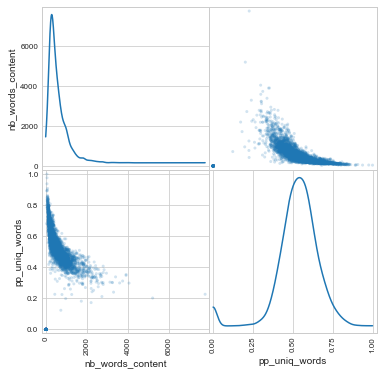

In [39]:
from pandas import scatter_matrix
scatter_matrix(train_data.get(["nb_words_content", "pp_uniq_words"]), alpha=0.2,
               figsize=(6, 6), diagonal='kde')

/Users/XQ/envs/scipy35/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


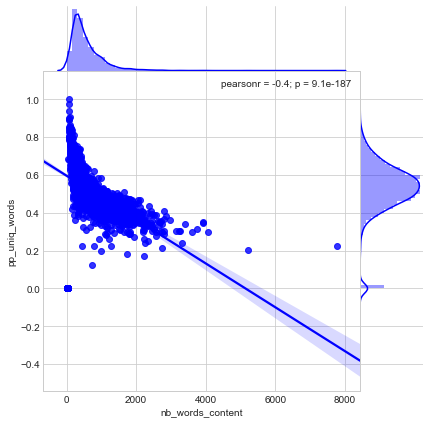

In [17]:
import seaborn.apionly as sns
sns.set_style('whitegrid')

sns.jointplot("nb_words_content", "pp_uniq_words", data = train_data, 
              kind='reg', size=6, space=0, color='b')

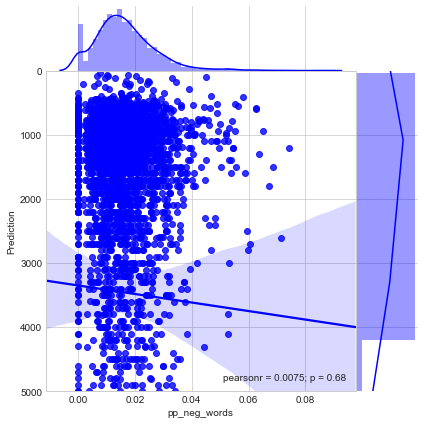

In [18]:
sns.jointplot(train_data["pp_neg_words"], target_data['Prediction'], 
              kind='reg', ylim=5000, size=6, space=0, color='b')

** Question: ** Change the features you display to explore relationships. What conclusions are you drawing from this exploratory analysis? Are you going to keep all the features in your predictors?

__Answer:__

# 2. Data transformation

### 2.1 feature engineering
This notion includes all kinds of manual modification and creation of features. All are of course problem dependant.
* __Encoding categorical features:__ if a K-categorical feature is not ordered (categorie 1 is as far to categorie 2 as to categorie 3 etc), then it must not be encoded by a single integer specifying the categorie. We can encode such feature by creating K-1 binary features encoding the belonging to k-th category. (see [link](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features))
* __Feature binarization:__ some continuous features can gain predictive power when binarized. For exemple, in some prediction tasks, weekdays could be split into $working\ days$ and $not\ working\ days$. (see [link](http://scikit-learn.org/stable/modules/preprocessing.html#binarization))
* __Imputation of missing values:__ there are multiple strategies to input missing values when required (see [link](http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values)). There is no missing value for any feature of the KaggleInClass challenge.
* __Dealing with time features or other periodic features:__ when considering the hour of the day as a feature, we can't encode it by the an integer between 1 and 24 as midnigth is as close to 11pm to 1am. An easy strategy to encode periodic features is to apply this transformation $x \mapsto \sin(\frac{2\pi x}{T})$ (T is the period). In the case of the hour of the day, it is   $x \mapsto \sin(\frac{2\pi x}{24})$. 
* __Generating new features:__ you might want to combine the existing features into new ones that seem informative to you. It can be useful for exemple, notably when working with linear models, to generate polynomial features from the original ones. You can also use external data to transform your features; for instance, if one feature is a date, adding a feature that qualifies whether the day is a working day, a weekday or a holiday can be useful.  
* ...

In many practical cases, feature engineering is the key to obtaining a huge improvement in performance.

** Question: ** How do you want to engineer the features of the challenge (first, you can start encoding the categorical features)? Keep thinking of this question all along the challenge.

Let us encode weekdays as a categorical feature rather than a periodic one. Remember this transformation later in the challenge: does it help your performance?

In [19]:
# Get the weekday data and encode it using a dummy categorical encoding
weekday_data = pd.get_dummies(train_data['weekday'], prefix='weekday', drop_first=True)

# Get the rest of the data
other_data = train_data.drop(['weekday'], axis=1)

# Create a new data set by concatenation of the new weekday data and the old rest of the data
training_data = pd.concat([weekday_data, other_data], axis=1)

# Print the created training data.
training_data.head(5)

,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,nb_words_title,nb_words_content,pp_uniq_words,pp_stop_words,...,pp_neg_words,pp_pos_words_in_nonneutral,ave_polar_pos,min_polar_pos,max_polar_pos,ave_polar_neg,min_polar_neg,max_polar_neg,subj_title,polar_title
2000,1,0,0,0,0,0,9,843,0.5358,2.092000e-09,...,0.019230,0.7143,0.4437,0.03333,1.0,-0.3160,-0.8000,-0.05,0.0,0.0
2001,0,1,0,0,0,0,9,805,0.4196,2.165000e-09,...,0.025710,0.5349,0.3081,0.05000,0.8,-0.3463,-0.7143,-0.10,0.9,0.3
2002,0,0,0,0,0,0,8,145,0.7594,1.163000e-08,...,0.007519,0.8333,0.3673,0.13640,0.5,-0.2000,-0.2000,-0.20,0.0,0.0
2003,0,1,0,0,0,0,12,201,0.6359,9.259000e-09,...,0.027030,0.7368,0.3721,0.13640,0.6,-0.4000,-0.4000,-0.40,0.0,0.0
2004,0,1,0,0,0,0,13,673,0.4609,2.500000e-09,...,0.021440,0.5625,0.3500,0.05000,0.6,-0.2435,-0.8000,-0.10,0.0,0.0


__Question:__ Repeat the process for the other categorical variable(s) in your data. Do not forget to apply your transformation to the test dataset as well!

In [20]:
# TODO

### 2.2 Preprocessing data: standardization
Standardization of a dataset is a common requirement for many machine learning estimators: many algorithms are built on the assumption that the individual features look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance) and might behave badly if this is not the case. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

Scikit-learn offers tools to deal with this issue ([link](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling))

In [21]:
from sklearn import preprocessing
#X_scaled = preprocessing.scale(X)

Let us visualize the distribution of some the features of the data. Be careful when standardizing features with outliers! 

/Users/XQ/envs/scipy35/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


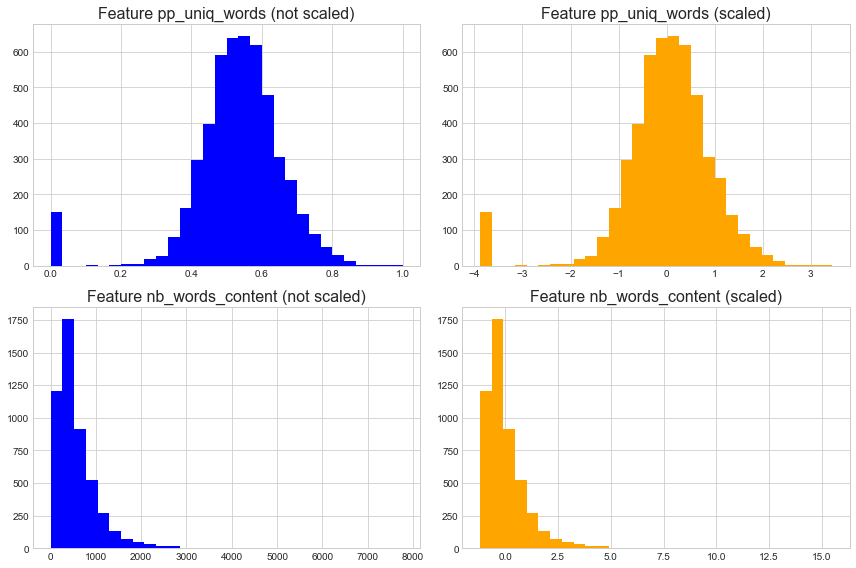

In [22]:
fig = plt.figure(figsize=(12, 8)) # (width, height)

feature_1 = 'pp_uniq_words'
fig.add_subplot(221) # 2 x 2 grid, 1st subplot
h = plt.hist(training_data[feature_1].values, bins=30, color='blue')
plt.title('Feature %s (not scaled)' % feature_1, fontsize=16)

fig.add_subplot(222) # 2 x 2 grid, 2nd subplot
h = plt.hist(preprocessing.scale(training_data[feature_1].values), bins=30, color='orange')
plt.title('Feature %s (scaled)' % feature_1, fontsize=16)

feature_2 = 'nb_words_content'
fig.add_subplot(223) # 2 x 2 grid, 3rd subplot
h = plt.hist(training_data[feature_2].values, bins=30, color='blue')
plt.title('Feature %s (not scaled)' % feature_2, fontsize=16)

fig.add_subplot(224) # 2 x 2 grid, 4th subplot
h = plt.hist(preprocessing.scale(training_data[feature_2].values), bins=30, color='orange')
plt.title('Feature %s (scaled)' % feature_2, fontsize=16)

plt.tight_layout() # improve spacing between subplots

### 2.3 Preprocessing data: sample normalization
Normalization is the process of scaling individual samples to have unit norm. It can be useful when using machine learning algorithms that use the distance between samples.

We will further discuss normalization in the next labs.

In [23]:
#X_norm = preprocessing.normalize(X)

### 2.4 Unsupervised projection
If your number of features is high, it may be useful to reduce it with an unsupervised step prior to supervised steps. 

We have already worked on a widly used dimentionality reduction method in `Lab 1`, the Principal Component Analysis. 

We will discuss in `Lab 5` the combinaison of dimentionality reduction and a predictor.

### 2.5 Feature selection
See [link](http://scikit-learn.org/stable/modules/feature_selection.html).

It may be useful to select a restricted number of important features to increase their predictive power. When the number of feature is particularly bigger than the number od instance, this issue of major importance.

Multiple strategies can be considered depending on the problem such like:
* considering the most varying features, condering the most correlated features to the output etc
* using feed forward selection procedure: recursively adding features one by one by incresing improvement of performance
* using embbeded feature selection like lasso or ElasticNet (see lab 5)
* computing feature importance (via bagging procedure like [randomized lasso](https://stat.ethz.ch/~nicolai/stability.pdf) or bagging trees (see lab 5) for exemple) and thresholding the feature.
* ...

# 3. Model evaluation and model selection

### 3.1 Our first classifier: Gaussian Naive Bayes
Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html 

In order to start thinking about model evaluation and model selection, we will convert the regression problem of the KaggleInClass challenge into a classification task in order to to work with the first classifier we studied in class: the Gaussian Naive Bayes.

Our goal here is to try to classify points between astonishingly and not astonishingly shared articles. Based on the distribution of the number of shares, the separation can be set at 1800 shares.

In [24]:
# Transform output into a classification task.
y_clf = np.where(y_tr >= 1800, 1, 0)
print(np.where(y_clf==0)[0].shape)
print(np.where(y_clf==1)[0].shape)

(2991,)
(2009,)


In [25]:
X_clf = training_data.values

In [26]:
# import Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

In [27]:
# create a Gaussian Naive Bayes classifier i.e. an instance of GaussianNB
gnb = GaussianNB()

In [28]:
# fit the classifier to the data
gnb.fit(X_clf, y_clf)

GaussianNB(priors=None)

In [29]:
# predict on the same data
y_pred = gnb.predict(X_clf)

In [30]:
# compute the number of mislabeled articles
print("Number of mislabeled points out of a total %d points : %d" % \
      (X_clf.shape[0], (y_clf != y_pred).sum()))

Number of mislabeled points out of a total 5000 points : 1963


Note than all predictors implemented in the sklearn library are trained and applied via the `fit` and `predict` (or `predict_proba`) methods.

**Question:** What are the parameters of the model we have trained? How many of them are they? How can you access them?

In [31]:
# Hint
gnb.__dict__

{'class_count_': array([ 2991.,  2009.]),
 'class_prior_': array([ 0.5982,  0.4018]),
 'classes_': array([0, 1]),
 'priors': None,
 'sigma_': array([[  4.80711374e+01,   4.80785654e+01,   4.80672040e+01,
           4.80357333e+01,   4.79605544e+01,   4.79599492e+01,
           5.23574670e+01,   2.00484574e+05,   4.79333339e+01,
           4.79439006e+01,   4.79381009e+01,   1.46923696e+02,
           1.29730972e+02,   1.08452677e+02,   6.43746048e+01,
           4.85357853e+01,   5.16087360e+01,   5.09308454e+01,
           4.58833111e+03,   2.70535460e+06,   7.88311247e+04,
           3.16905236e+09,   4.67115687e+10,   1.77537953e+10,
           1.12425412e+06,   1.99926793e+07,   1.41124704e+06,
           2.14915154e+08,   9.25165735e+08,   3.47575175e+08,
           4.79779402e+01,   4.79686235e+01,   4.80040740e+01,
           4.79957998e+01,   4.79949409e+01,   4.79285792e+01,
           4.79239664e+01,   4.79153324e+01,   4.79151514e+01,
           4.79526437e+01,   4.79259205e

### 3.2 Model Evaluation

You must have a look at http://scikit-learn.org/stable/modules/model_evaluation.html which shows and details a list of metrics for evaluating regression or classification models.

In the case of regression, the most commonly used metrics are :
* `mean squared errors`
* `mean absolute errors` which gives less importance to errors of very bad prediction and more importance to errors of good predictions as the following plot shows than `mean squared errors`
* `R2` (coefficient of determination) which provides a measure of how well future samples are likely to be predicted by the model.

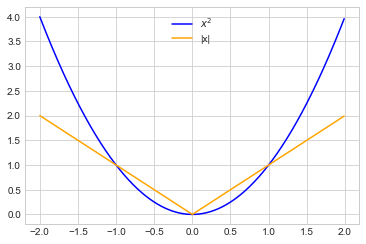

In [40]:
x = np.arange(-2,2,0.01)
plt.plot(x,x*x, 'blue', label='$x^2$')
plt.plot(x,abs(x), 'orange', label='|x|')
plt.legend(loc="upper center")
plt.show()

In the case of classification, lots of metrics are used depending on the considered problem:

* `accuracy` is a default performance measure computing the proportion of missclassified tested instances
* `sensitivity` or 'true positive rate' is the proportion of well classified positive samples
* `specificity` or 'true negative rate' is the proportion of well classified negative samples

* `precision` is the ability of the classifier not to label as positive a sample that is negative. Like in the case of cancer, we really want to avoid diagnose a cancer to somebody who does not have one.
* `recall` is the ability of the classifier to find all the positive samples.
    
* `the area under the precision-recall curve`
* `the area under the Receiver operating characteristic (ROC) curve`  

**Question** Use the sklearn library to compute the accuracy score of the above prediction.

In [41]:
from sklearn import metrics
# Score the predictions
print("Accuracy: %.3f" % # TODO
         )

SyntaxError: invalid syntax (<ipython-input-41-ca6bc17e12f5>, line 4)

Building an ROC curve requires to use the probability estimates for the test data points *before* they are thresholded.

In [ ]:
# Predict probability estimates instead of 0/1 class labels
y_prob = gnb.predict_proba(X_clf)
print(y_prob.shape)

**Question:** `y_prob` returns two values for each data point because it returns one probability estimate per class for each data point. The order in which the classes appear are given by `gnb.classes_ `. How do you get the 1-dimensional array that only contains the estimated probability for each point to belong to the positive class?

In [ ]:
pos_index = list(gnb.classes_).index(1)

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_clf, y_prob[:, pos_index], pos_label=1)

# Area under the ROC curve
auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, '-', color='orange', label='AUC = %0.3f' % auc)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Gaussian Naive Bayes', fontsize=16)
plt.legend(loc="lower right")

**Question:** What is it problematic to have evaluated our classifier on the training data? 

### 3.3 Model Selection: cross-validation

We will now use the function `make_Kfolds` you have implemented in the first section to evaluate the accuracy of your model via a 5-fold cross-validation scheme. We will compare the results you obtained with those you get with scikit-learn's implementation of the cross-validation scheme. 

In [ ]:
# Set up a cross-validation with make_Kfolds
perso_folds = # TODO

# Set up a cross-validation with sklearn
sk_folds = # TODO

In [ ]:
# Assess performance using the cross_validate function you have implemented
# On perso_folds
gnb = GaussianNB()
y_prob_cv_perso = # TODO use cross_validate and perso_folds
print("Your own cv-scheme: Accuracy: %.3f" % #TODO
     )

# On sk_folds
gnb = GaussianNB()
y_prob_cv_sk = # TODO use cross_validate and perso_folds
print("Sklearn cv-scheme: Accuracy: %.3f" % # TODO
     )

We will now plot the ROC curve corresponding to your predictions.

In [ ]:
# Compute the ROC curve corresponding to the y_prob_cv_perso predictions
fpr, tpr, thresholds = metrics.roc_curve(y_clf, y_prob_cv_perso, pos_label=1)

# Area under the ROC curve
auc = metrics.auc(fpr, tpr)
print("Your own cv-scheme: AUROC: %.3f" % auc)

# Plot the ROC curve
plt.plot(fpr, tpr, '-', color='orange', label='AUC = %0.3f' % auc)

# TODO: plot in blue the ROC curve corresponding to the y_prob_cv_sk predictions

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Gaussian Naive Bayes', fontsize=16)
plt.legend(loc="lower right")

__Question:__ The `sklearn.cross_validation` module provides some utilities to make cross-validated predictions. Compare the results you obtained to what they return.

Documentation: [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [ ]:
gnb = GaussianNB()
skf = model_selection.StratifiedKFold(5, shuffle=True, random_state=91)

# Use model_selection.cross_val_score to compute the average cross-validated roc_auc score 
# of gnb on (X_clf, y_clf), using the skf iterator.
cv_aucs = # TODO

print(np.mean(cv_aucs))

# Note that averaging the AUCs obtained over 10 folds is not the same as 
# globally computing the AUC for the predictions made within the cross-validation loop.

__Question__ Compare scikit-learn's implementation of the cross-validation with yours.

In [ ]:
gnb = GaussianNB()
skf = model_selection.StratifiedKFold(5, shuffle=True, random_state=91)

# Compute the cross-validation accuracy using model_selection.cross_val_predict
y_pred_sk = model_selection.cross_val_predict(# TODO
     )
print("Cross-validated accuracy: %.3f" %  metrics.accuracy_score(# TODO
     ))

# Compute the cross-validation accuracy using your own cross_validate function
y_prob_cv = cross_validate(# TODO
    )
# Transform y_prob_cv into a vector of binary predictions
y_pred_perso = # TODO 
print("Cross-validated accuracy: %.3f" %  metrics.accuracy_score(# TODO
     ))

__Question:__ Does stratifying the cross-validation make a difference?

__Answer:__